In [80]:
from Py6S import *
import numpy as np
%matplotlib widget
import ipywidgets as widgets
from matplotlib import pyplot as plt
from matplotlib.widgets import Cursor

In [2]:
def wattsToPhotons(radwatts,waves):
    return radwatts/(1.98644582e-25/(waves*1e-6))

def convertRadAtSatLevelToPhotonsCapturedBySensor(radwatts, waves, apeture, efl, pixelsize, int_time, dlam, QE, inst_trans):
    phots=wattsToPhotons(radwatts,waves)
    
    fnum=efl/apeture
    A=pixelsize**2
    SLDangle=apeture**2 * np.pi / (4*efl**2)
    
    captured_phots = phots * int_time * A * SLDangle * dlam * inst_trans * QE
    
    return captured_phots

# Run 6SV simulation to estimate radiance received by sensor in orbit.
Uses the Py6SV wrapper and mostly default values for now. Gemortry is set to obsevere Jervis Bay at 11am, nadir pointing (I think).

In [3]:
s = SixS("/Users/chrisbetters/DropboxSydneyUni/postdoc/projects/CUAVA/CUAVA3/6S/6sV-2.1/sixsV2.1")

#s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.Tropical)

s.altitudes.set_sensor_satellite_level()
s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.MidlatitudeSummer)
#s.ground_reflectance = GroundReflectance.HomogeneousLambertian(GroundReflectance.GreenVegetation)
s.geometry = Geometry.User()
s.geometry.from_time_and_location(-35.0481, 150.7447, "06:00:00", 0, 0) #% 11am AEDT above jervis bay.

wv, res = SixSHelpers.Wavelengths.run_wavelengths(s,np.arange(0.400, 1, 0.01), output_name='pixel_radiance')

Running for many wavelengths - this may take a long time


# Interactive S/N calc

The papramets can be adjusted in the plot ot the effect on the S/N. 
- *Aperture* is the diameter of the entrance aperture of the sensor in mm
- *EFL* is effiective focal length in mm
- *pixelsize* is the size of a spatial pixel on the sensor in micrometers. (i.e. raw pixel size on the ximea linescane sensor or the slit size in spectrograh based design (note I assume in that case Entenue is conserved by the spec).
- *int_time* is the inegration time of the sensor in ms.
- *dlam* is the spectral resolution of the instrument (or the width of spectral bands).

In [4]:
# set up plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.grid(True)
ax.autoscale(True, 'both', True)
 
@widgets.interact(apeture=(10, 100, 1), efl=(100, 1000, 20), pixelsize=(5.5, 60, 0.5),int_time=(1,10,1),dlam=(0.1,50,0.1))
def update(apeture = 45, efl=700, pixelsize=5.5, int_time=2, dlam=15):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    
    SN=np.sqrt(convertRadAtSatLevelToPhotonsCapturedBySensor(radwatts=res,
                                                              waves=wv, 
                                                              apeture=apeture*1e-3, 
                                                              efl=efl*1e-3, 
                                                              pixelsize=pixelsize*1e-6, 
                                                              int_time=int_time*1e-3,
                                                              dlam=dlam*1e-3, 
                                                              QE=0.7, 
                                                              inst_trans=0.8))
    ax.set_title("Mean S/N: {:.2f}".format(np.nanmean(SN)))
    #ax.set_ylim([0, np.nanmax(SN)*1.1])
    ax.plot(wv, SN, color='C0')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=45, description='apeture', min=10), IntSlider(value=700, description='ef…

# Signal plots at various conversion points.

In [5]:
captured_phots = convertRadAtSatLevelToPhotonsCapturedBySensor(radwatts=res,
                                                              waves=wv, 
                                                              apeture=45e-3, 
                                                              efl=700*1e-3, 
                                                              pixelsize=5.5e-6, 
                                                              int_time=2e-3,
                                                              dlam=0.015, 
                                                              QE=0.7, 
                                                              inst_trans=0.8)

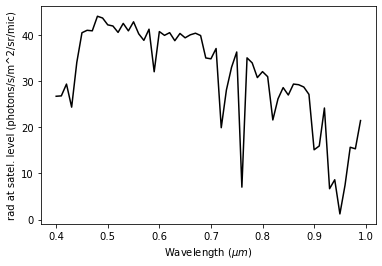

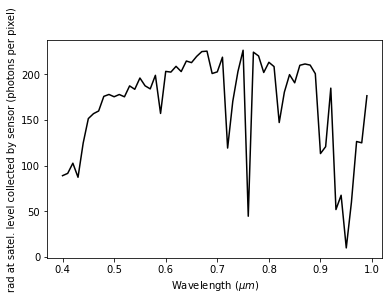

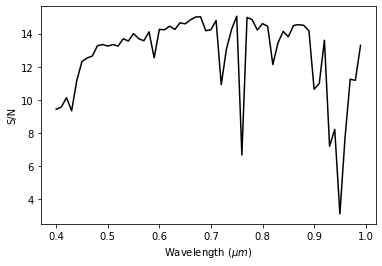

In [6]:
%matplotlib inline
SixSHelpers.Wavelengths.plot_wavelengths(wv, res, "rad at satel. level (photons/s/m^2/sr/mic)")
SixSHelpers.Wavelengths.plot_wavelengths(wv, captured_phots, "rad at satel. level collected by sensor (photons per pixel)")
SixSHelpers.Wavelengths.plot_wavelengths(wv, captured_phots/np.sqrt(captured_phots), "S/N")

# Generate plot of F/# vs GSD and corresponding mean S/N

In [7]:
def loopOverEFL(res, wv, apeture, pixelsize, dlam):
    loopfnum=[]
    loopgsd=[]
    loopsn=[]
    loopefl=[]
    loopint_time=[]
    
    
    for fnum in range(3, 20, 1):        
        efl=fnum*apeture
        gsd=550e3/efl*1e-3 * pixelsize
        maxexposuretime=0.1318*gsd  #https://www.wolframalpha.com/input/?i=1m+%2F+sqrt%28Gravitational+constant+*mass+of+earth%2F%28radius+of+earth+%2B+550km%29%29+in+ms
        captured_phots= convertRadAtSatLevelToPhotonsCapturedBySensor(radwatts=res,
                                                                      waves=wv, 
                                                                      apeture=apeture*1e-3, 
                                                                      efl=efl*1e-3, 
                                                                      pixelsize=pixelsize*1e-6, 
                                                                      int_time=maxexposuretime*1e-3,
                                                                      dlam=dlam*1e-3,
                                                                      QE=0.7, 
                                                                      inst_trans=0.8)

        loopfnum.append(fnum)
        loopgsd.append(gsd)
        loopsn.append(np.nanmean(np.sqrt(captured_phots)))
        loopefl.append(efl)
        loopint_time.append(maxexposuretime)
        
    return (loopfnum, loopgsd, loopsn, loopefl, loopint_time)
    
(loopfnum, loopgsd, loopsn, loopefl, loopint_time) = loopOverEFL(res,wv, 95, 5.5, 15)
    
#         print("F/#: {}".format(fnum))
#         print("Resolution Element Size: {} m, for EFL: {} mm".format(550e3/efl *2 *pixelsize,efl*1e3))
#         print("Mean S/N: {}".format(np.nanmean(np.sqrt(captured_phots))))

[6.358771929824561,
 4.7690789473684205,
 3.815263157894737,
 3.1793859649122806,
 2.725187969924812,
 2.3845394736842103,
 2.1195906432748535,
 1.9076315789473686,
 1.7342105263157894,
 1.5896929824561403,
 1.467408906882591,
 1.362593984962406,
 1.2717543859649123,
 1.1922697368421051,
 1.1221362229102168,
 1.0597953216374267,
 1.004016620498615]

In [19]:
%matplotlib widget
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.set_title('GSD vs mean S/N')

ax1.set_xlabel('GSD (m)')
ax1.set_ylabel('S/N')


ax1.plot(loopgsd, loopsn)
ax1.tick_params(axis='y')
plt.grid(True)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

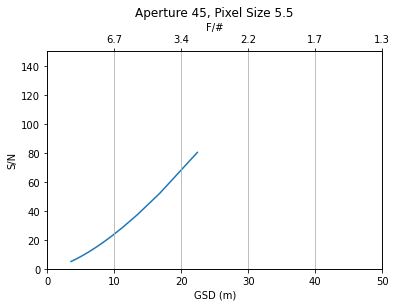

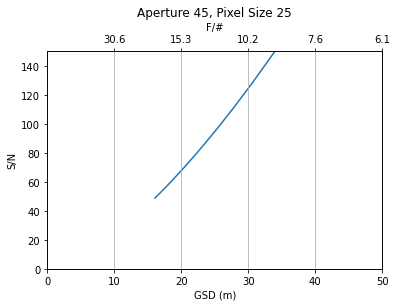

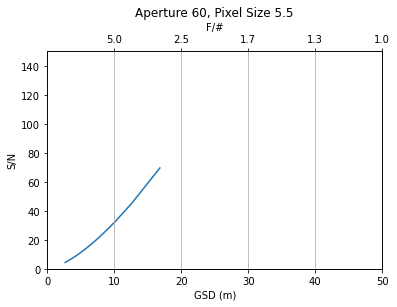

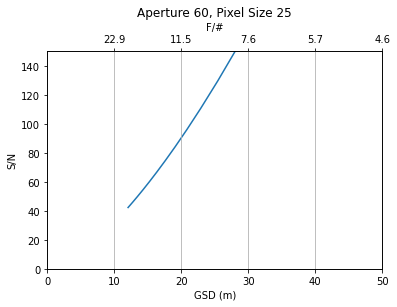

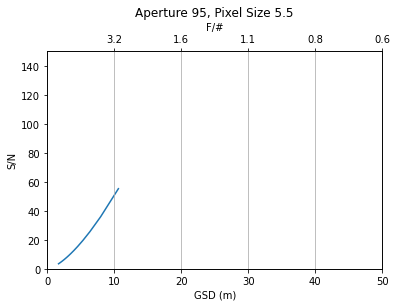

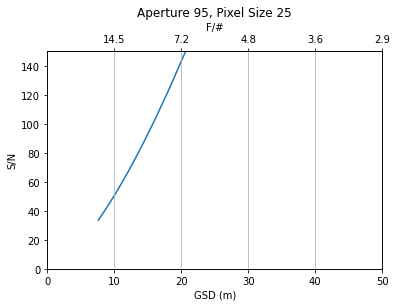

In [86]:
Ds=[45, 60, 95]
pixs=[5.5, 25]

def tick_function(gsd,pixelsize,D):
    efl =550e3/gsd*1e-3 * pixelsize / D
    
    return ["%.1f" % z for z in efl]

for D in range(len(Ds)):
    for pix in range(len(pixs)):
        (loopfnum, loopgsd, loopsn, loopefl,loopint_time) = loopOverEFL(res,wv, Ds[D], pixs[pix], 15)

        %matplotlib inline
#         fig, ax1 = plt.subplots(figsize=(6, 4))
#         ax1.set_title('F/# vs GSD and mean S/N - Aperture {}, Pixel Size {}'.format(Ds[D],pixs[pix]))
#         color = 'tab:red'
#         ax1.set_xlabel('F/#')
#         ax1.set_ylabel('S/N', color=color)


#         ax1.plot(loopfnum, loopsn, color=color)
#         ax1.tick_params(axis='y', labelcolor=color)
#         plt.grid(True)
#         ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#         color = 'tab:blue'
#         ax2.set_ylabel('GSD (m)', color=color)  # we already handled the x-label with ax1
#         ax2.plot(loopfnum, loopgsd, color=color,linestyle='dashed')
#         ax2.tick_params(axis='y', labelcolor=color)
#         plt.ylim(0,100)
#         fig.tight_layout()  # otherwise the right y-label is slightly clipped
#         plt.show()


        
        fig, ax1 = plt.subplots(figsize=(6, 4))
        ax2 = ax1.twiny()
        ax1.set_title('Aperture {}, Pixel Size {}'.format(Ds[D],pixs[pix]))

        ax1.set_xlabel('GSD (m)')
        ax1.set_ylabel('S/N')
        
        
        ax1.plot(loopgsd, loopsn)
        #ax1.tick_params(axis='y')
        ax1.set_xlim(0,50)
        ax1.set_ylim(0,150)
        plt.grid(True)
        #fig.tight_layout()  # otherwise the right y-label is slightly clipped
        
        new_tick_locations = ax1.get_xticks() #np.array([5, 10, 15])
        
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_xticks(new_tick_locations[1:])
        ax2.set_xticklabels(tick_function(new_tick_locations[1:],pixs[pix],Ds[D]))
        ax2.set_xlabel('F/#')
        
        plt.show()

In [85]:
%matplotlib widget
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.set_title('F/# vs GSD and mean S/N')
color = 'tab:red'
ax1.set_xlabel('F/#')
ax1.set_ylabel('S/N', color=color)
ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
colorax2 = 'tab:blue'


@widgets.interact(apeture=(10, 100, 1),  pixelsize=(5.5, 60, 0.5), dlam=(0.1,50,0.1))
def update(apeture = 45, pixelsize=5.5, dlam=15):
    """Remove old lines from plot and plot new one"""
    ax1.clear() 
    ax2.clear()
    
    
    (loopfnum, loopgsd, loopsn, loopefl,loopint_time) = loopOverEFL(res,wv, apeture, pixelsize, dlam)
    
    
    ax1.set_title('Aperture {}, Pixel Size {}'.format(apeture,pixelsize))

    ax1.set_xlabel('GSD (m)')
    ax1.set_ylabel('S/N')
    
    ax1.plot(loopgsd, loopsn)
    #ax1.tick_params(axis='y')
#     ax1.set_xlim(0,50)
#     ax1.set_ylim(0,150)
    plt.grid(True)
    #fig.tight_layout()  # otherwise the right y-label is slightly clipped

    new_tick_locations = ax1.get_xticks() #np.array([5, 10, 15])

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations[1:])
    ax2.set_xticklabels(tick_function(new_tick_locations[1:],pixs[pix],Ds[D]))
    ax2.set_xlabel('F/#')
    cursor = Cursor(ax1, useblit=True, color='red', linewidth=2)

    plt.show()
        

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=45, description='apeture', min=10), FloatSlider(value=5.5, description='…